# transformations in augmented reality

In [ ]:
# File upload
from google.colab import files
uploaded = files.upload()

## 1. import libraries



In [ ]:
import cv2
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

## 2. Read data



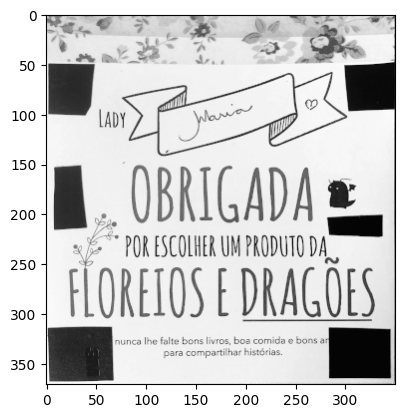

In [ ]:
# Load reference image and convert it to gray scale
referenceImage = cv2.imread('/content/referenceImage.jpg', 0)

# Show image
plt.imshow(referenceImage, cmap='gray')
plt.show()

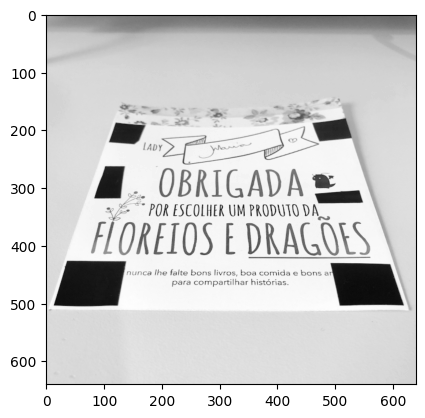

In [ ]:
# Load the source image and convert it to gray scale
sourceImage = cv2.imread('/content/sourceImage_01.jpg', 0)

# Show image
plt.imshow(sourceImage, cmap='gray')
plt.show()

## 3. Recognize

* 3.1 Feature detection & description

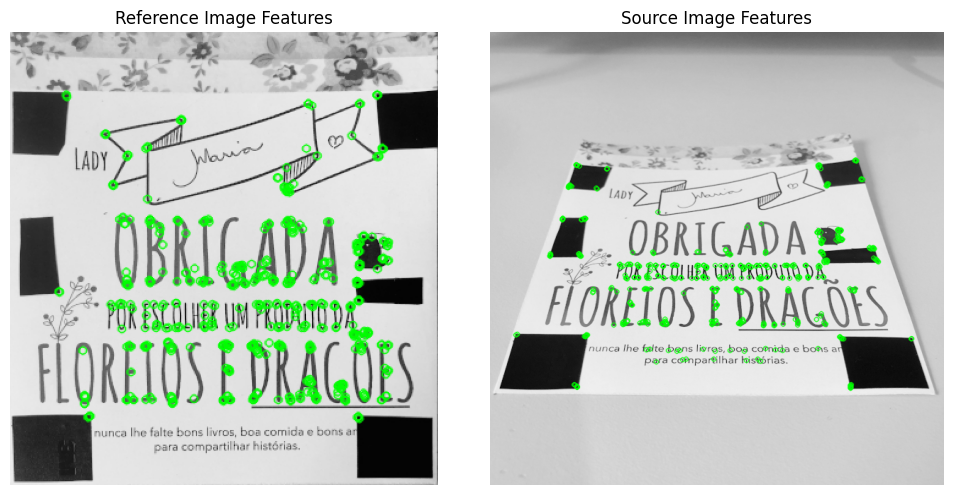

In [ ]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
referenceImagePts = orb.detect(referenceImage, None)
sourceImagePts = orb.detect(sourceImage, None)

# compute the descriptors with ORB
referenceImagePts, referenceImageDsc = orb.compute(referenceImage, referenceImagePts)
sourceImagePts, sourceImageDsc = orb.compute(sourceImage, sourceImagePts)

#  Paint the key points over the original image
referenceImageFeatures = cv2.drawKeypoints(referenceImage, referenceImagePts,
                                           referenceImage, color=(0,255,0), flags=0)
sourceImageFeatures = cv2.drawKeypoints(sourceImage, sourceImagePts,
                                           sourceImage, color=(0,255,0), flags=0)


# Show image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(referenceImageFeatures, cmap='gray')
plt.title('Reference Image Features')
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(sourceImageFeatures, cmap='gray')
plt.title('Source Image Features')
plt.tight_layout()
plt.show()

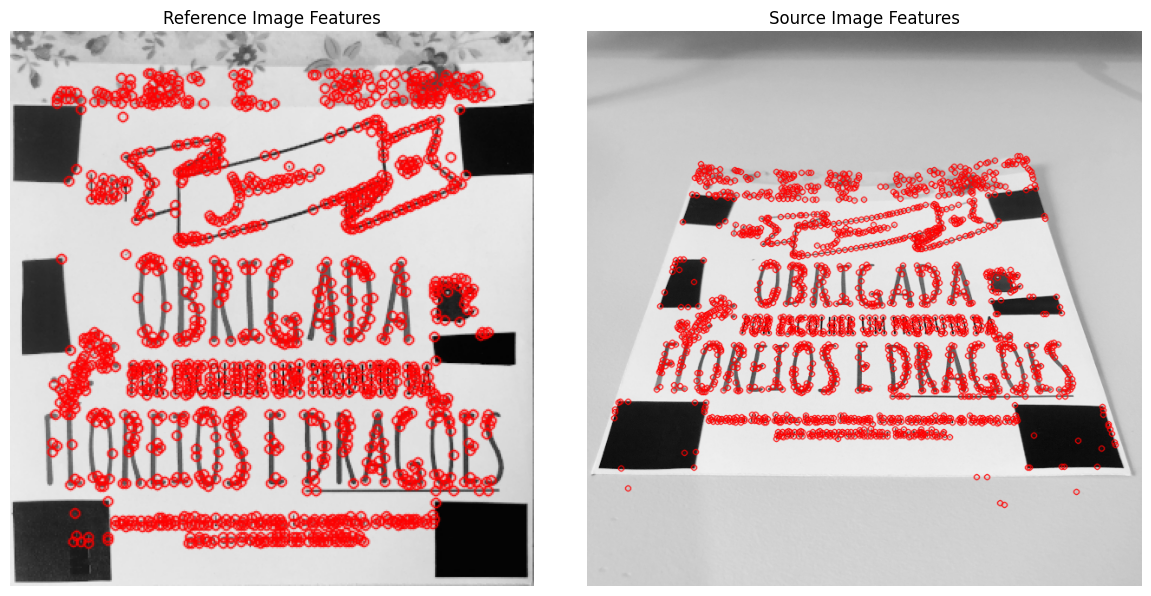

In [ ]:
# Initialize the BRIEF detector
fast = cv2.FastFeatureDetector_create()

# Detect keypoints using BRIEF for both images
referenceImagePts = fast.detect(referenceImage, None)
sourceImagePts = fast.detect(sourceImage, None)

# Initialize the BRIEF descriptor
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

# Compute the BRIEF descriptors for the keypoints in both images
referenceImagePts, referenceImageDsc = brief.compute(referenceImage, referenceImagePts)
sourceImagePts, sourceImageDsc = brief.compute(sourceImage, sourceImagePts)

# Draw keypoints on the images
referenceImageFeatures = cv2.drawKeypoints(referenceImage, referenceImagePts, None, color=(255, 0, 0))
sourceImageFeatures = cv2.drawKeypoints(sourceImage, sourceImagePts, None, color=(255, 0, 0))

# Display the original images with keypoints
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(referenceImageFeatures, cmap='gray')
plt.title('Reference Image Features')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sourceImageFeatures, cmap='gray')
plt.title('Source Image Features')
plt.axis('off')

plt.tight_layout()
plt.show()

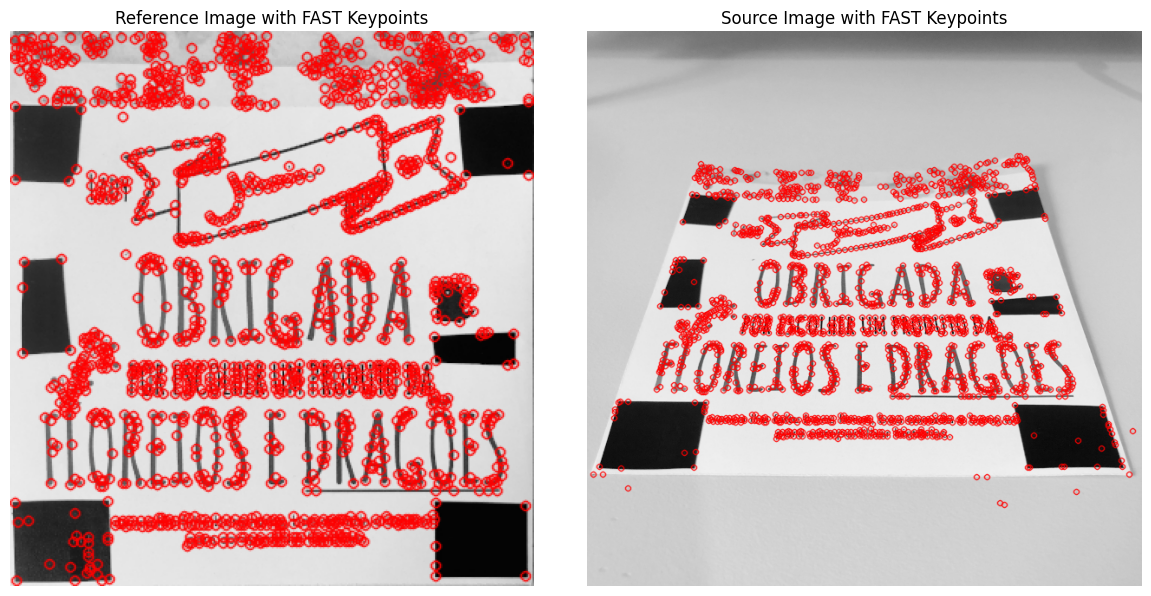

In [ ]:
# Initialize the FAST detector
fast = cv2.FastFeatureDetector_create()

# Detect keypoints using FAST for both images
referenceKeypoints = fast.detect(referenceImage, None)
sourceKeypoints = fast.detect(sourceImage, None)

# Draw the keypoints on the images
referenceImageWithKeypoints = cv2.drawKeypoints(referenceImage, referenceKeypoints, None, color=(255, 0, 0))
sourceImageWithKeypoints = cv2.drawKeypoints(sourceImage, sourceKeypoints, None, color=(255, 0, 0))

# Display the original images with keypoints
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(referenceImageWithKeypoints, cmap='gray')
plt.title('Reference Image with FAST Keypoints')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sourceImageWithKeypoints, cmap='gray')
plt.title('Source Image with FAST Keypoints')
plt.axis('off')

plt.tight_layout()
plt.show()

* 3.2 Feature matching

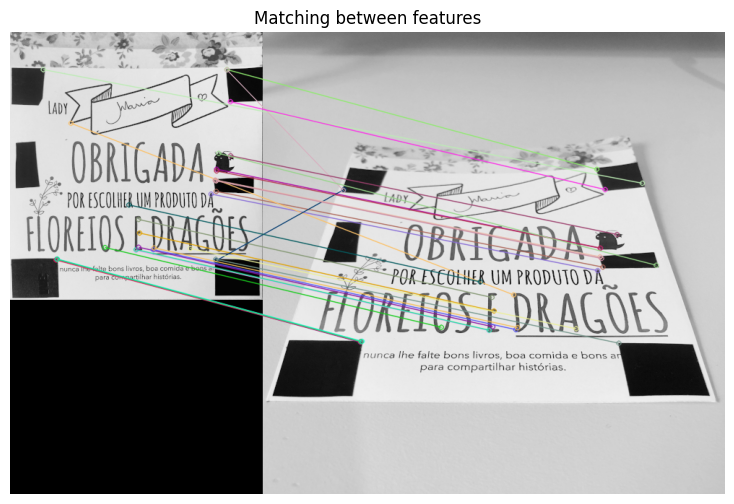

In [ ]:
MIN_MATCHES = 30

# create brute force  matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Compute model keypoints and its descriptors
referenceImagePts, referenceImageDsc = orb.detectAndCompute(referenceImage, None)

# Compute scene keypoints and its descriptors
sourceImagePts, sourceImageDsc = orb.detectAndCompute(sourceImage, None)

# Match frame descriptors with model descriptors
matches = bf.match(referenceImageDsc, sourceImageDsc)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

if len(matches) > MIN_MATCHES:
    # draw first 15 matches.
    idxPairs = cv2.drawMatches(referenceImage, referenceImagePts, sourceImage, sourceImagePts,
                          matches[:MIN_MATCHES], 0, flags=2)
    # show result
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.imshow(idxPairs, cmap='gray')
    plt.title('Matching between features')
    plt.show()

else:
    print("Not enough matches have been found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

#NNDR (Nearest Neighbor Distance Ratio) method

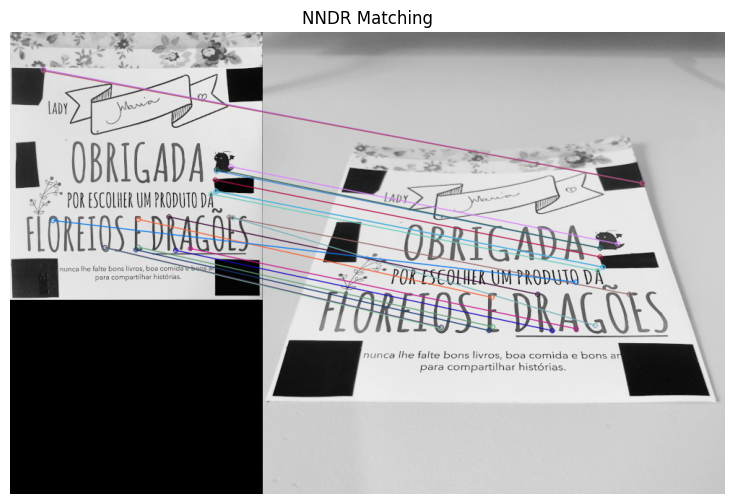

In [ ]:
MIN_MATCHES = 20

def nndr_matching(img1, img2):
    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Use BFMatcher with default params
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    # Match descriptors using knn
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply NNDR
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:  # NNDR ratio < 0.75
            good_matches.append(m)

    return kp1, kp2, good_matches

# Load images
img1 = cv2.imread('/content/referenceImage.jpg', cv2.IMREAD_GRAYSCALE)  # Change the path as needed
img2 = cv2.imread('/content/sourceImage_01.jpg', cv2.IMREAD_GRAYSCALE)   # Change the path as needed

# Apply NNDR matching
kp1, kp2, good_matches = nndr_matching(img1, img2)

# Draw matches if there are enough good matches
if len(good_matches) > MIN_MATCHES:
    # Draw the matches
    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[:MIN_MATCHES], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Show result
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.imshow(matched_img)
    plt.title('NNDR Matching')
    plt.show()
else:
    print("Not enough matches have been found - %d/%d" % (len(good_matches), MIN_MATCHES))

## 4. Homography


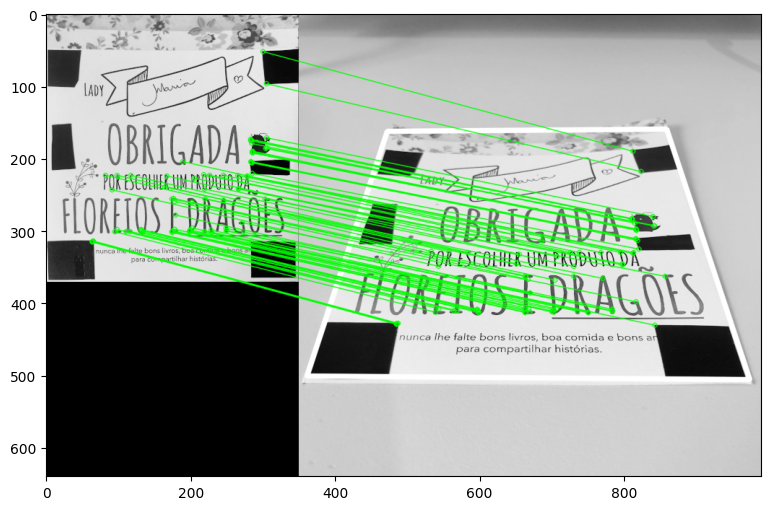

In [ ]:
# Apply the homography transformation if we have enough good matches
if len(matches) > MIN_MATCHES:
    # Get the good key points positions
    sourcePoints = np.float32([referenceImagePts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([sourceImagePts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    # Obtain the homography matrix
    homography, mask = cv2.findHomography(sourcePoints, destinationPoints, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Apply the perspective transformation to the source image corners
    h, w = referenceImage.shape
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, homography)

    # Draw a polygon on the second image joining the transformed corners
    sourceImageMarker = cv2.polylines(sourceImage, [np.int32(transformedCorners)], True,
                                      255, 5, cv2.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

# Draw the matches
drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None,
                      matchesMask=matchesMask, flags=2)
result = cv2.drawMatches(referenceImage, referenceImagePts, sourceImageMarker,
                         sourceImagePts, matches, None, **drawParameters)

# Show image
plt.figure(figsize=(12, 6))
plt.imshow(result, cmap='gray')
plt.show()

## 5. Pose Estimation

In [ ]:
import pywavefront
import numpy as np

# Camera parameters
camera_parameters = np.array([[1000, 0, 320], [0, 1000, 240], [0, 0, 1]])

# Load 3D model from OBJ file without requiring the .mtl file
obj = pywavefront.Wavefront('/content/chair.obj', create_materials=True, collect_faces=True)



Unimplemented OBJ format statement 's' on line 's 1'
Unimplemented OBJ format statement 's' on line 's 1'
Unimplemented OBJ format statement 's' on line 's 1'
Unimplemented OBJ format statement 's' on line 's 1'
Unimplemented OBJ format statement 's' on line 's 1'
Unimplemented OBJ format statement 's' on line 's 1'


In [ ]:
import numpy as np
import math

# projection_matrix function
def projection_matrix(camera_parameters, homography):

    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]

    # normalise vectors
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l

    # compute the orthonormal basis
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_3 = np.cross(rot_1, rot_2)

    # finally, compute the 3D projection matrix from the model to the current frame
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T

    return np.dot(camera_parameters, projection)


In [ ]:
import cv2

# Rotation matrix to rotate the model from lying down to standing up (around X-axis)
def rotate_model(vertices):
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, 0, -1],
        [0, 1, 0]
    ])
    return np.dot(vertices, rotation_matrix.T)

# Render function
def render(img, obj, projection, model, color=False):
    """ Renders a loaded Wavefront obj model onto the frame using the projection matrix """
    vertices = obj.vertices
    scale_matrix = np.eye(3) * 6
    h, w = model.shape

    # Rotate the model so it stands up
    rotated_vertices = rotate_model(vertices)

    # Iterate over the meshes and faces in obj.mesh_list
    for mesh in obj.mesh_list:
        for face in mesh.faces:
            face_vertices = [rotated_vertices[vertex] for vertex in face]  # Adjusted to get vertices by index
            points = np.array(face_vertices)
            points = np.dot(points, scale_matrix)

            # Move model points to the middle of the reference surface
            points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
            dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
            imgpts = np.int32(dst)

            cv2.fillConvexPoly(img, imgpts, (80, 27, 211))

    return img


In [ ]:
# Apply the homography transformation if we have enough good matches
if len(matches) > MIN_MATCHES:
    # Get the good key points positions
    sourcePoints = np.float32([referenceImagePts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([sourceImagePts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    # Obtain the homography matrix
    homography, _ = cv2.findHomography(sourcePoints, destinationPoints, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Apply the perspective transformation to the source image corners
    h, w = referenceImage.shape
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, homography)

    # Draw a polygon on the second image joining the transformed corners
    frame = cv2.polylines(sourceImage, [np.int32(transformedCorners)], True, 255, 3, cv2.LINE_AA)

    # Obtain 3D projection matrix from homography matrix and camera parameters
    projection = projection_matrix(camera_parameters, homography)

    # Project cube or model using the updated render function with rotation
    frame = render(frame, obj, projection, referenceImage, False)


## 6. Display

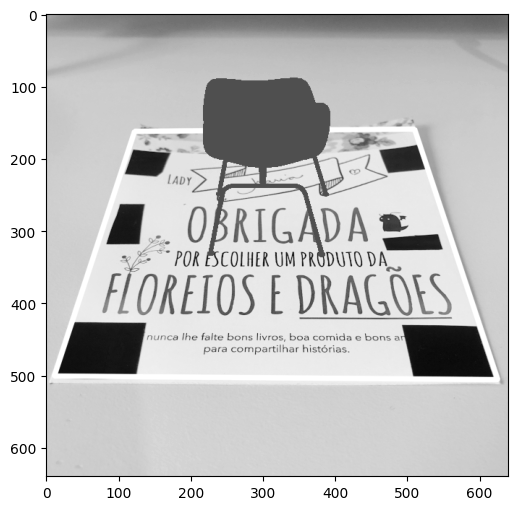

In [ ]:
# Show image
plt.figure(figsize=(12, 6))
plt.imshow(frame, cmap='gray')
plt.show()

In [ ]:
import pywavefront
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Define a function to compute the projection matrix
def projection_matrix(camera_parameters, homography):
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = np.cross(col_1, col_2)
    translation = rot_and_transl[:, 2]

    projection = np.stack((col_1, col_2, col_3, translation)).T
    return np.dot(camera_parameters, projection)

# Function to apply rotation to the 3D model to face the camera
def rotate_model(vertices, angle=np.pi):
    rotation_matrix = np.array([
        [np.cos(angle), 0, np.sin(angle)],
        [0, 1, 0],
        [-np.sin(angle), 0, np.cos(angle)]
    ])
    return np.dot(vertices, rotation_matrix.T)

# Function to render the 3D model and axes on the image
def render(image, obj, projection, model_image, scale=1, offset=(0, 0), draw_axes=False):
    vertices = np.array(obj.vertices)
    vertices = rotate_model(vertices)  # Rotate model to face the camera
    scale_matrix = np.eye(3) * scale
    h, w, _ = model_image.shape  # Adjust for color image

    # Adjust position based on offset (center the model in the image)
    offset_matrix = np.array([w / 2 + offset[0], h / 2 + offset[1], 0])

    # Iterate over meshes and their faces
    for mesh in obj.mesh_list:
        for face in mesh.faces:
            points = np.array([vertices[vertex - 1] for vertex in face])
            points = np.dot(points, scale_matrix) + offset_matrix  # Apply scale and offset
            projected_points = cv2.perspectiveTransform(np.array([points]), projection)[0]

            # Convert to int
            projected_points = np.int32(projected_points)

            # Set a default color for the face (if materials are not available)
            color = (137, 27, 211)  # Default purple color

            # Draw the faces on the image with the default color
            cv2.fillConvexPoly(image, projected_points, color)

    if draw_axes:
        # Define 3D axis lines (X, Y, Z) in 3D space
        axis_length = 100
        axis_points = np.float32([
            [0, 0, 0],  # Origin
            [axis_length, 0, 0],  # X-axis
            [0, axis_length, 0],  # Y-axis
            [0, 0, -axis_length]  # Z-axis (negative for right-handed coordinate system)
        ]).reshape(-1, 3)

        # Project the 3D axis lines into the 2D image
        projected_axes = cv2.perspectiveTransform(np.array([axis_points]), projection)[0]

        origin = tuple(np.int32(projected_axes[0]))  # Origin point
        x_axis = tuple(np.int32(projected_axes[1]))  # X-axis end point
        y_axis = tuple(np.int32(projected_axes[2]))  # Y-axis end point
        z_axis = tuple(np.int32(projected_axes[3]))  # Z-axis end point

        # Draw the axes on the image
        cv2.arrowedLine(image, origin, x_axis, (0, 0, 255), 3, tipLength=0.05)  # Red X-axis
        cv2.arrowedLine(image, origin, y_axis, (0, 255, 0), 3, tipLength=0.05)  # Green Y-axis
        cv2.arrowedLine(image, origin, z_axis, (255, 0, 0), 3, tipLength=0.05)  # Blue Z-axis

    return image

# Define a function to render the airplane model on the reference image with axes
def render_airplane_on_image(reference_image_path, source_image_path, airplane_model_path, camera_parameters, scale=1, offset=(0, 0), draw_axes=False):
    # Check if the model file exists
    if not os.path.exists(airplane_model_path):
        print(f"Model file not found: {airplane_model_path}")
        return

    # Load the reference and source images
    reference_image = cv2.imread(reference_image_path)
    source_image = cv2.imread(source_image_path)

    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors for both images
    reference_keypoints, reference_descriptors = orb.detectAndCompute(reference_image, None)
    source_keypoints, source_descriptors = orb.detectAndCompute(source_image, None)

    # Create BFMatcher object to match descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(reference_descriptors, source_descriptors)
    matches = sorted(matches, key=lambda x: x.distance)

    MIN_MATCHES = 10
    if len(matches) > MIN_MATCHES:
        # Extract the matched keypoints
        ref_pts = np.float32([reference_keypoints[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        src_pts = np.float32([source_keypoints[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        # Compute the homography matrix
        homography, mask = cv2.findHomography(ref_pts, src_pts, cv2.RANSAC, 5.0)

        # Load the 3D airplane model from the .obj file
        obj = pywavefront.Wavefront(airplane_model_path, create_materials=True, collect_faces=True)

        # Check the contents of the loaded model
        if not obj.mesh_list:
            print("No meshes found in the model.")
            return  # Exit the function or handle the error

        # Project the 3D airplane model onto the source image
        projection = projection_matrix(camera_parameters, homography)
        frame_with_airplane = render(source_image, obj, projection, reference_image, scale=scale, offset=offset, draw_axes=draw_axes)

        # Display the image with the 3D airplane model and axes overlaid
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(frame_with_airplane, cv2.COLOR_BGR2RGB))
        plt.title('3D Airplane Model Rendered on Source Image with Axes')
        plt.axis('on')
        plt.show()

    else:
        print(f"Not enough matches were found: {len(matches)}/{MIN_MATCHES}")

# Set file paths
reference_image_path = '/content/referenceImage.jpg'  # Path to the reference image
source_image_path = '/content/sourceImage_03.jpg'    # Path to the source image
airplane_model_path = 'airplane.obj'  # Path to the 3D airplane model

# Define camera parameters
camera_parameters = np.array([[1000, 0, 320], [0, 1000, 240], [0, 0, 1]])

# Scale and offset for better fitting
scale = 0.1  # Adjust the scale of the airplane model to fit within the image
offset = (0, 0)  # Offset to center the model in the image

# Call the function to render the airplanes
render_airplane_on_image(reference_image_path, source_image_path, airplane_model_path, camera_parameters, scale=scale, offset=offset, draw_axes=True)
